<a href="https://colab.research.google.com/github/manal-0603/Weather-Forecasting-using-Machine-Learning-algorithms/blob/main/LGBMRegressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*texte en italique*# **<center><font style="color:rgb(100,109,254)">Weather Forecasting using Machine Learning algorithms</font> </center>**

<center>
<img src='https://www.analyticssteps.com/backend/media/thumbnail/6006173/6278986_1571298721_Weather_Forecoast_Graphics.jpg'></center>

In [24]:
# Importation des bibliothèques nécessaires
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time
from sklearn.model_selection import TimeSeriesSplit
import missingno as msno
from scipy.stats import skew

In [25]:
import pandas as pd

# Charger les dataset
donnnes_meteo = pd.read_csv('donnees_meteo.csv')

In [26]:
# Verifier que l'index est de type 'Timestamp'
donnnes_meteo.index = pd.to_datetime(donnnes_meteo["datetime"])

donnnes_meteo['year'] = pd.to_datetime(donnnes_meteo["datetime"]).dt.year

# Diviser les données en fonction de la date
train_data = donnnes_meteo[donnnes_meteo.index.year < 2020]  # Données d'entraînement jusqu'à 2019
val_data = donnnes_meteo[donnnes_meteo.index.year == 2020]   # Données de validation en 2020
test_data = donnnes_meteo[donnnes_meteo.index.year >= 2021]  # Données de test à partir de 2021

In [47]:
selected_columns_train =[ 'dew', 'humidity', 'precip',
       'precipprob', 'windgust', 'windspeed', 'winddir',
       'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation',
       'solarenergy', 'uvindex', 'conditions_Clear',
       'conditions_Overcast', 'conditions_Partially cloudy', 'conditions_Rain',
       'conditions_Rain, Fog', 'conditions_Rain, Overcast',
       'conditions_Rain, Partially cloudy']


X_train, y_train = train_data[selected_columns_train], train_data['temp']
X_test, y_test = test_data[selected_columns_train], test_data['temp']
X_val, y_val = val_data[selected_columns_train], val_data['temp']

X_train = X_train.rename(columns={'conditions_Rain, Fog': 'conditions_Rain_Fog', 'conditions_Rain, Overcast' : 'conditions_Rain_Overcast', 'conditions_Rain, Partially cloudy' : 'conditions_Rain_Partially cloud'})
X_test = X_test.rename(columns={'conditions_Rain, Fog': 'conditions_Rain_Fog', 'conditions_Rain, Overcast' : 'conditions_Rain_Overcast', 'conditions_Rain, Partially cloudy' : 'conditions_Rain_Partially cloud'})

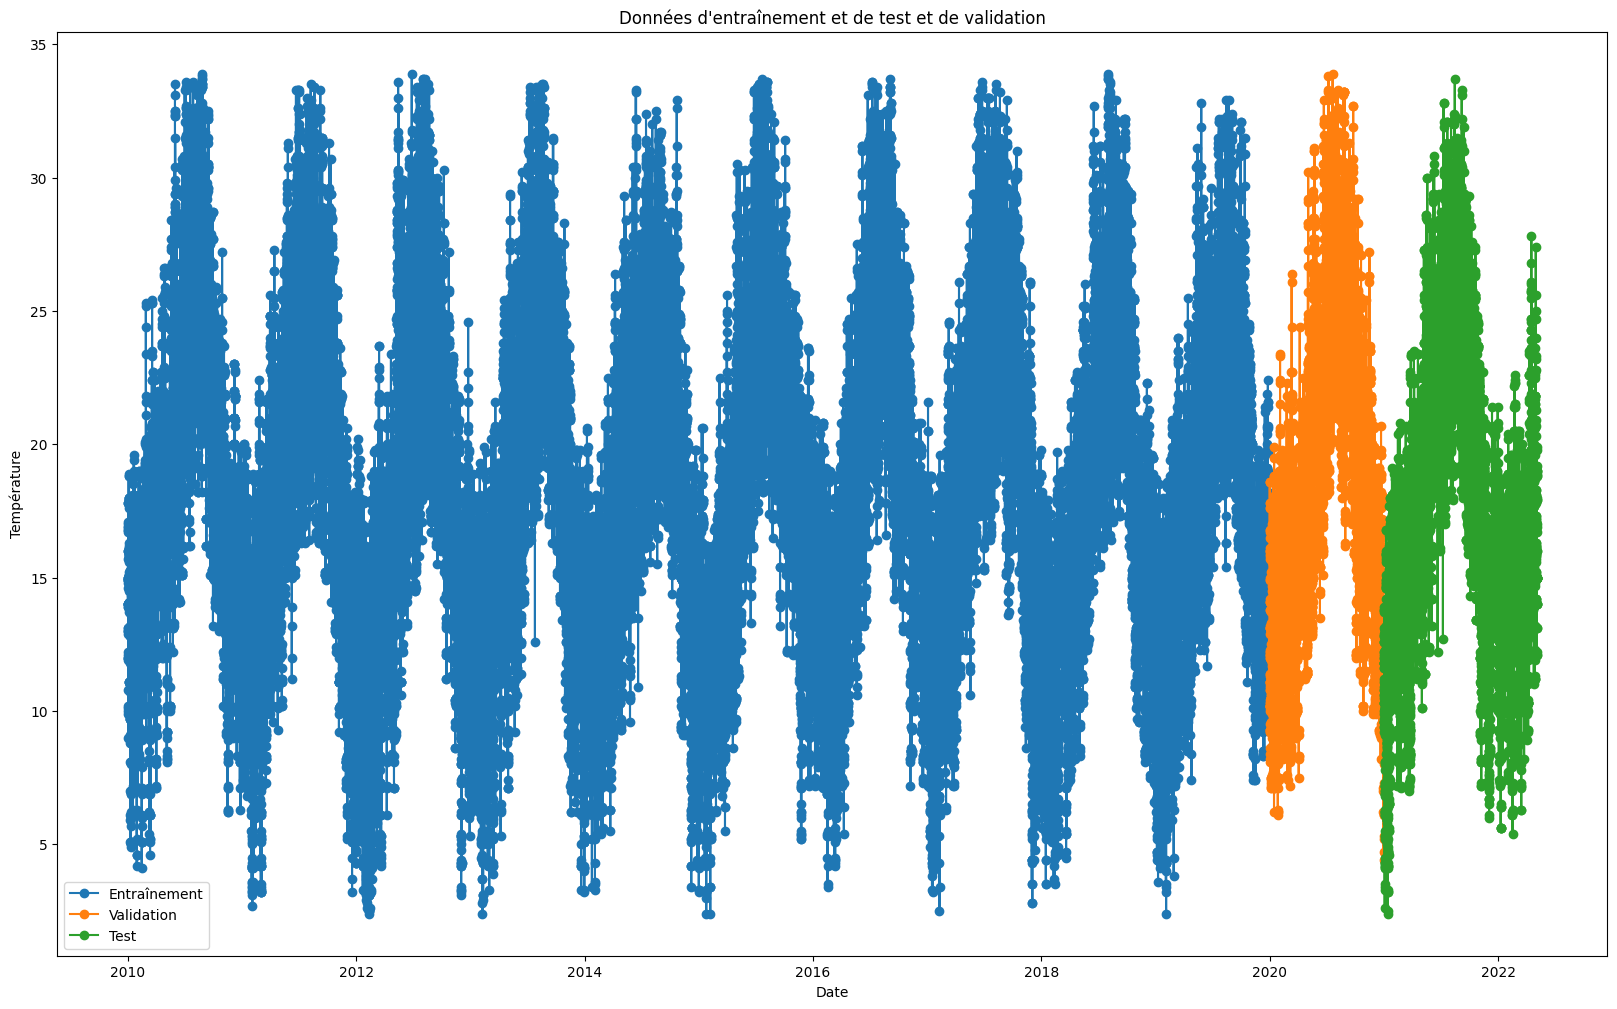

In [48]:
# Créer un graphe
plt.figure(figsize=(20, 12))

# Tracer les données d'entraînement
plt.plot(train_data.index, y_train, label='Entraînement', marker='o')

# Tracer les données de test
plt.plot(val_data.index, y_val, label='Validation', marker='o')

# Tracer les données de test
plt.plot(test_data.index, y_test, label='Test', marker='o')

# Ajouter des étiquettes et un titre
plt.xlabel('Date')
plt.ylabel('Température')
plt.title('Données d\'entraînement et de test et de validation')

# Ajouter une légende
plt.legend()


<font size='3' face='cursive'>

# **<font color="#FF1646" >1. Modèles Non Linéaires </font>**

</font>

<font size='4' face='MathJax_Math-italic'>

## **<font color='blue' >LightGBM</font>**

LGBMRegressor est un modèle d'apprentissage automatique basé sur le gradient boosting, conçu pour le problème de régression. Il appartient à la famille des modèles de boosting, qui construisent des modèles de prédiction par étapes successives, en ajustant chaque modèle pour corriger les erreurs des modèles précédents.

###**Comment fonctionne un LightGBM ?**

* #### **LightGBM (Light Gradient Boosting Machine) :** Il tire son nom de son implémentation légère et rapide du boosting par gradient. Contrairement à d'autres bibliothèques de boosting comme XGBoost ou GradientBoosting de scikit-learn, LightGBM est conçu pour être très efficace en termes de temps de calcul et de mémoire. Il utilise une approche de type histogramme pour la construction de l'arbre, ce qui lui permet d'être plus rapide et plus efficace.

* #### **Arbres de décision boostés :**
  Comme les autres modèles de boosting, LGBMRegressor construit son modèle en combinant plusieurs arbres de décision faibles. Chaque arbre est ajusté successivement pour corriger les erreurs du modèle précédent. L'objectif est de minimiser une fonction de perte spécifique (généralement l'erreur quadratique moyenne pour la régression).

* #### **Boosting par gradient :**
  Le boosting par gradient est une technique d'apprentissage ensembliste où chaque arbre est ajusté en fonction du gradient de la fonction de perte par rapport à la prédiction actuelle du modèle. Cela permet de guider la construction de chaque arbre dans la bonne direction pour réduire l'erreur globale du modèle.

* #### **Optimisation de la fonction de perte :**
  LGBMRegressor optimise la fonction de perte directement lors de la construction des arbres. Il utilise des techniques avancées telles que le "Leaf-wise growth" pour construire les arbres de manière efficace et rapide.

* #### **Élagage :**
  LightGBM utilise un algorithme d'élagage pour éviter le surajustement. Il arrête la croissance des arbres lorsque la perte ne diminue pas suffisamment après l'ajout d'un nouveau nœud.


▶ ▶ LGBMRegressor est un modèle de régression basé sur le gradient boosting, conçu pour être rapide, efficace en termes de mémoire et capable de produire des prédictions précises même sur de grands ensembles de données. Il utilise une combinaison de boosting par gradient, d'arbres de décision et de techniques d'optimisation avancées pour atteindre ces objectifs.


<font size='4' face='MathJax_Math-italic'>

## **<font color='green' >Construction du model</font>**



In [49]:
# Initialisation des listes pour stocker les scores et les erreurs
test_scores = []
train_scores = []
errors = []

for n_estimators in range(1, 50):  # Nous pouvons choisir une plage appropriée pour n_estimators

    # Création du modèle LGBMRegressor avec la valeur actuelle de n_estimators
    lgbm_regressor = LGBMRegressor(n_estimators=n_estimators, random_state=42)

    # Entraîner le modèle sur l'ensemble d'entraînement
    lgbm_regressor.fit(X_train, y_train)

    # Faire des prédictions sur l'ensemble de test
    y_pred = lgbm_regressor.predict(X_test)

    # Stocker les scores pour l'analyse ultérieure
    train_scores.append(lgbm_regressor.score(X_train, y_train))
    test_scores.append(lgbm_regressor.score(X_test, y_test))

    # Stocker les erreurs pour l'analyse ultérieure
    errors.append(mean_squared_error(y_test, y_pred))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2379
[LightGBM] [Info] Number of data points in the train set: 87646, number of used features: 19
[LightGBM] [Info] Start training from score 18.338078
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011941 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2379
[LightGBM] [Info] Number of data points in the train set: 87646, number of used features: 19
[LightGBM] [Info] Start training from score 18.338078
[LightGBM] [Warning] Found

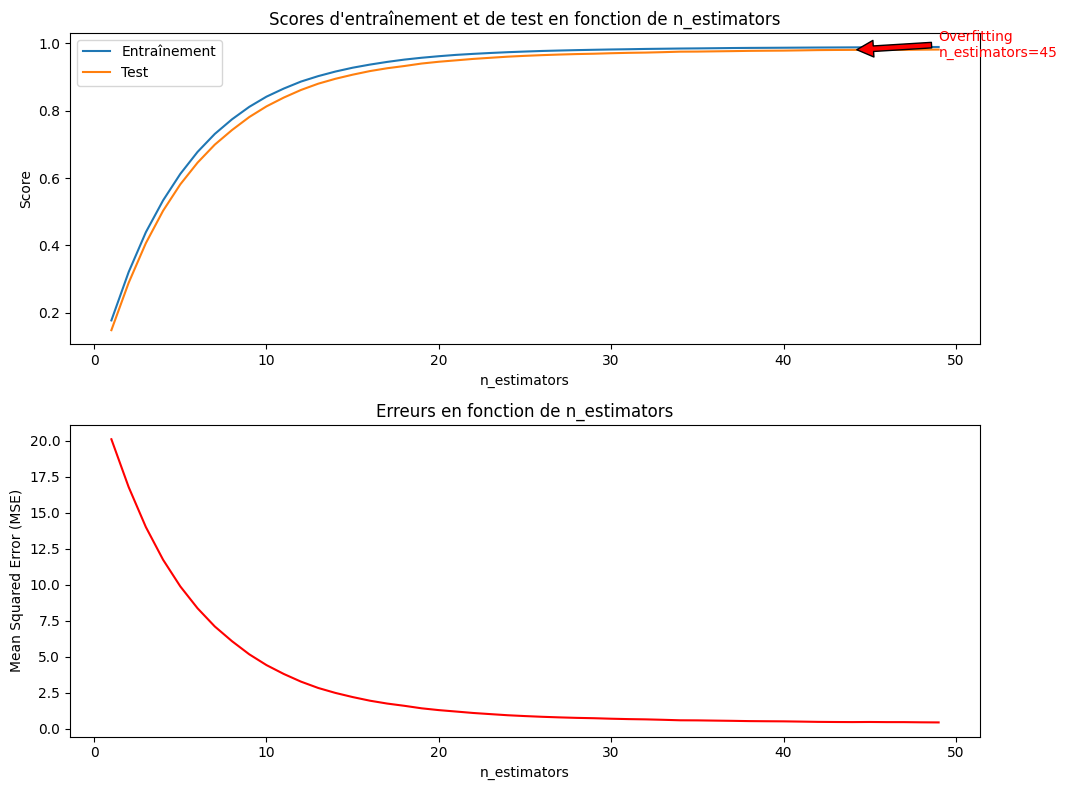

In [51]:
import matplotlib.pyplot as plt

# Créer une figure avec deux sous-graphiques
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Graphique des scores
ax1.plot(range(1, 50), train_scores, label='Entraînement')
ax1.plot(range(1, 50), test_scores, label='Test')
ax1.set_title('Scores d\'entraînement et de test en fonction de n_estimators')
ax1.set_xlabel('n_estimators')
ax1.set_ylabel('Score')
ax1.legend()

# Graphique des erreurs
ax2.plot(range(1, 50), errors, color='red')
ax2.set_title('Erreurs en fonction de n_estimators')
ax2.set_xlabel('n_estimators')
ax2.set_ylabel('Mean Squared Error (MSE)')

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()


# Trouver l'indice du point où l'overfitting commence
overfitting_point = None
for i in range(1, len(test_scores)):
    if test_scores[i] <= test_scores[i - 1]:
        overfitting_point = i
        break

# Ajouter une annotation si l'overfitting est détecté
if overfitting_point is not None:
    n_estimators_at_overfitting = range(1, 50)[overfitting_point]
    ax1.annotate(f'Overfitting\nn_estimators={n_estimators_at_overfitting}',
                 xy=(overfitting_point, test_scores[overfitting_point]),
                 xytext=(overfitting_point + 5, test_scores[overfitting_point] - 0.02),
                 arrowprops=dict(facecolor='red', shrink=0.05),
                 fontsize=10, color='red')


# Afficher les graphiques
plt.show()

<font size='4' face='MathJax_Math-italic'>


En examinant attentivement les graphiques, on peut déduire plusieurs tendances intéressantes :

## **Overfitting et Underfitting :**
### **Underfitting (Sous-ajustement) :**

Pour des valeurs très faibles de max_depth, on peut remarquer que mes scores d'entraînement et de test sont plutôt bas, ce qui semble indiquer que mon modèle ne s'ajuste pas suffisamment aux données.

### **Overfitting (Surajustement) :**

À mesure que max_depth augmente, on voit clairement que mes scores d'entraînement augmentent rapidement. Cependant, il y a un point critique où mes scores de test commencent à stagner voire à diminuer, suggérant que mon modèle pourrait être trop ajusté aux données d'entraînement et ne généralise pas bien aux nouvelles données.


## **Choix de max_depth :**
Il semble crucial de trouver une valeur optimale pour max_depth qui assure à la fois un score élevé et une erreur faible sur mes données de test.

Je peux prendre comme indice l'endroit où les courbes de scores de test et d'entraînement semblent se stabiliser, ce qui pourrait indiquer un compromis optimal entre la complexité du modèle et sa capacité à généraliser.

## **Erreur Quadratique Moyenne (MSE) :**
En examinant la courbe d'erreur quadratique moyenne (MSE), je cherche à minimiser l'erreur. Il est crucial de garder à l'esprit que je ne veux pas sacrifier la généralisation pour atteindre une performance optimale sur mes données d'entraînement, afin d'éviter le surajustement.

Ces analyses visuelles me fournissent des indications importantes pour guider mon choix de max_depth. Cependant, je considère ces observations comme des points de départ, sachant que des ajustements supplémentaires et des méthodes automatisées comme GridSearchCV pourraient être nécessaires pour identifier les meilleurs hyperparamètres.



<font size='4' face='MathJax_Math-italic'>


## **<font color='green' >Optimisation des hyper paramètres</font>**


Les modèles de régression (ou de classification) sont des fonctions mathématiques qui dépendent d’hyperparamètres . Le réglage de ces hyperparamètres va impacter fortement le score final de ce modèle.

GridSearchCV permet de réaliser automatiquement la recherche des meilleurs hyperparamètres. L’utilisateur aura juste à préciser quels hyperparamètres il souhaite faire varier leurs niveaux de variation et GridSearchCV déterminera automatiquement le meilleur réglage.

In [89]:
# Initialiser le modèle LGBMRegressor avec le nombre de feuilles spécifié
lgbm_regressor = LGBMRegressor( random_state=42)

# Définir les hyperparamètres à ajuster
param_grid = {
    'n_estimators': range(1, 50),  # Nombre d'estimateurs
    'learning_rate': [0.01, 0.1, 1.0],  # Taux d'apprentissage
    'max_depth': [3, 5, 7],  # Profondeur maximale de l'arbre
    'min_child_weight': [1, 3, 5],  # Poids minimal des enfants
    'num_leaves': [15, 31, 63]  # Nombre de feuilles dans chaque arbre

}

# Mesurer le temps de début de la recherche par grille
lgbm_grid_search_start_time = time.time()

# Utiliser la recherche sur grille pour trouver les meilleurs hyperparamètres
tscv = TimeSeriesSplit(n_splits=5)  # Utilisation de TimeSeriesSplit pour la validation croisée
lgbm_grid_search = GridSearchCV(lgbm_regressor, param_grid, scoring='neg_mean_squared_error', cv=tscv)
lgbm_grid_search.fit(X_train, y_train)

# Mesurer le temps de fin de la recherche par grille
lgbm_grid_search_end_time = time.time()
lgbm_grid_search_elapsed_time = lgbm_grid_search_end_time - lgbm_grid_search_start_time

# Afficher les meilleurs hyperparamètres
best_params = lgbm_grid_search.best_params_
print("Meilleurs hyperparamètres:", best_params)

# Afficher la performance du modèle pour chaque combinaison d'hyperparamètres
cv_results = lgbm_grid_search.cv_results_
mse_values = -cv_results['mean_test_score']
params_list = cv_results['params']

# Mesurer le temps de début de l'entraînement avec les meilleurs hyperparamètres
lgbm_best_fit_start_time = time.time()

# Entraîner le modèle avec les meilleurs hyperparamètres sur l'ensemble d'entraînement complet
best_lgbm_regressor = lgbm_grid_search.best_estimator_
best_lgbm_regressor.fit(X_train, y_train)

# Mesurer le temps de fin de l'entraînement
lgbm_best_fit_end_time = time.time()
lgbm_best_fit_elapsed_time = lgbm_best_fit_end_time - lgbm_best_fit_start_time

# Faire des prédictions sur l'ensemble de test
y_pred_lgbm = best_lgbm_regressor.predict(X_test)

# Afficher le temps écoulé pour la recherche par grille, l'entraînement et la prédiction
print(f"Temps écoulé pour la recherche par grille: {lgbm_grid_search_elapsed_time} secondes")
print(f"Temps écoulé pour l'entraînement avec les meilleurs hyperparamètres: {lgbm_best_fit_elapsed_time} secondes")

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

<font size='4' face='MathJax_Math-italic'>

## **<font color='green' >Evaluation du model</font>**


Mean Squared Error: 0.3722497144926978


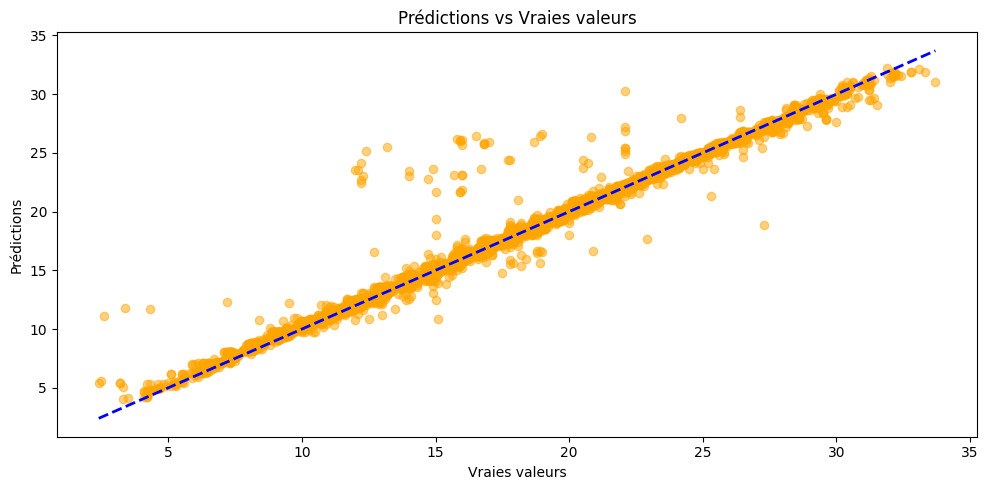

In [90]:
# Afficher les prédictions par rapport aux vraies valeurs
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred_lgbm, color='orange', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='blue', linewidth=2)
plt.xlabel('Vraies valeurs')
plt.ylabel('Prédictions')
plt.title('Prédictions vs Vraies valeurs')

# Calculer l'erreur quadratique moyenne (Mean Squared Error)
mse_lgbm = mean_squared_error(y_test, y_pred_lgbm)
print(f"Mean Squared Error: {mse_lgbm}")

plt.tight_layout()
plt.show()

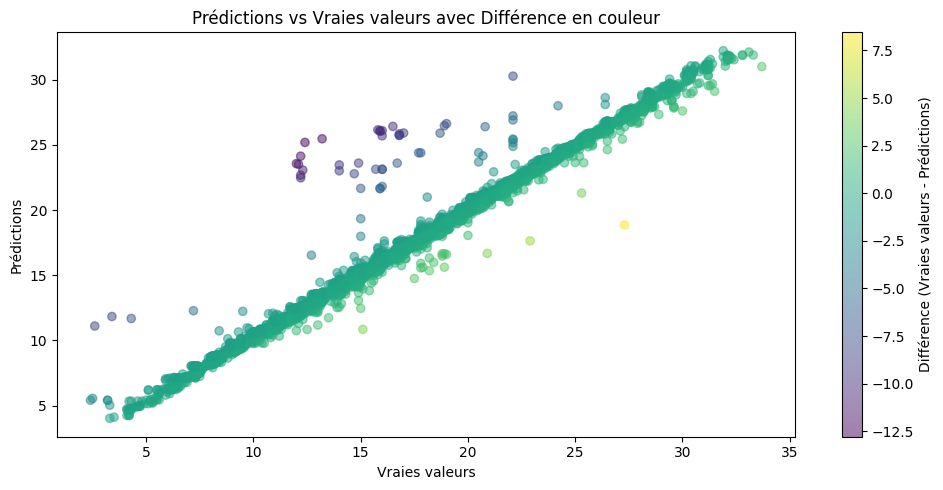

In [91]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred_lgbm, c=y_test - y_pred_lgbm, cmap='viridis', alpha=0.5)
plt.colorbar(label='Différence (Vraies valeurs - Prédictions)')
plt.xlabel('Vraies valeurs')
plt.ylabel('Prédictions')
plt.title('Prédictions vs Vraies valeurs avec Différence en couleur')
plt.tight_layout()
plt.show()

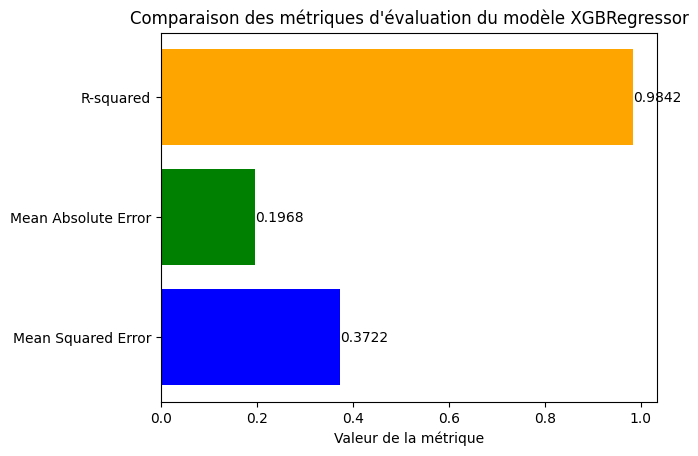

In [92]:
# Calculer différentes métriques pour XGBRegressor
mse_xgb = mean_squared_error(y_test, y_pred_lgbm)
mae_xgb = mean_absolute_error(y_test, y_pred_lgbm)
r2_xgb = r2_score(y_test, y_pred_lgbm)

# Mettre les métriques dans une liste pour faciliter la création du graphique
metrics_names = ['Mean Squared Error', 'Mean Absolute Error', 'R-squared']
metrics_values = [mse_xgb, mae_xgb, r2_xgb]

# Créer un graphique à barres horizontal
fig, ax = plt.subplots()
bars = ax.barh(metrics_names, metrics_values, color=['blue', 'green', 'orange'])

# Ajouter les valeurs à côté des barres
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.4f}',
             va='center', ha='left', color='black')

plt.xlabel('Valeur de la métrique')
plt.title('Comparaison des métriques d\'évaluation du modèle XGBRegressor')
plt.show()

<font size='4' face='MathJax_Math-italic'>

## **<font color='green' >Interprétabilité du model</font>**


Dans le domaine complexe et puissant de l'apprentissage automatique (machine learning), où des modèles sophistiqués sont capables d'effectuer des tâches complexes, l'interprétation des résultats devient essentielle. L'interprétabilité se réfère à la capacité de comprendre et d'expliquer le fonctionnement d'un modèle, en répondant aux questions cruciales telles que "Comment prend-il des décisions ?" ou "Pourquoi a-t-il prédit cela ?". Cette capacité à rendre les modèles compréhensibles est devenue une exigence fondamentale, en particulier dans des domaines sensibles tels que la santé, la finance et la justice, où des explications claires sont nécessaires.

L'interprétabilité peut être analysée à deux niveaux complémentaires : local et global :

## **<font color='orange' > Interprétabilité Locale :</font>**


L'interprétabilité locale se concentre sur la compréhension d'une prédiction spécifique générée par le modèle pour une observation particulière dans l'ensemble de données.

Elle répond à la question :

**"Pourquoi le modèle a-t-il pris cette décision pour cette observation spécifique ?"**



<font size='4' face='MathJax_Math-italic'>

## **<font color='navy' >SHAP (SHapley Additive exPlanations) </font>**
SHAP (SHapley Additive exPlanations) est basé sur la théorie des jeux et les valeurs de Shapley, qui proviennent du domaine de la théorie des coalitions. Cette méthode offre des explications individualisées et cohérentes pour les prédictions de modèles, que ce soit à l'échelle globale ou locale.

### **Interprétation Locale avec SHAP :**

* **Objectif :** Comprendre comment les caractéristiques influencent une prédiction spécifique du modèle pour une observation particulière.

* **Valeurs de Shapley Individuelles :**

  Pour une prédiction spécifique, SHAP attribue des valeurs de Shapley individuelles à chaque caractéristique. Ces valeurs représentent la contribution marginale de chaque caractéristique à la prédiction particulière.

* **Force de la Prédiction (Force Plot) :**

  Les "Force Plots" de SHAP illustrent graphiquement la contribution de chaque caractéristique à la différence entre la prédiction du modèle pour une instance spécifique et la valeur attendue (la valeur moyenne du modèle).

* **Graphiques d'Importance Locale :**

  Ces graphiques montrent visuellement comment chaque caractéristique contribue à la prédiction pour une observation donnée.




In [93]:
!pip install shap

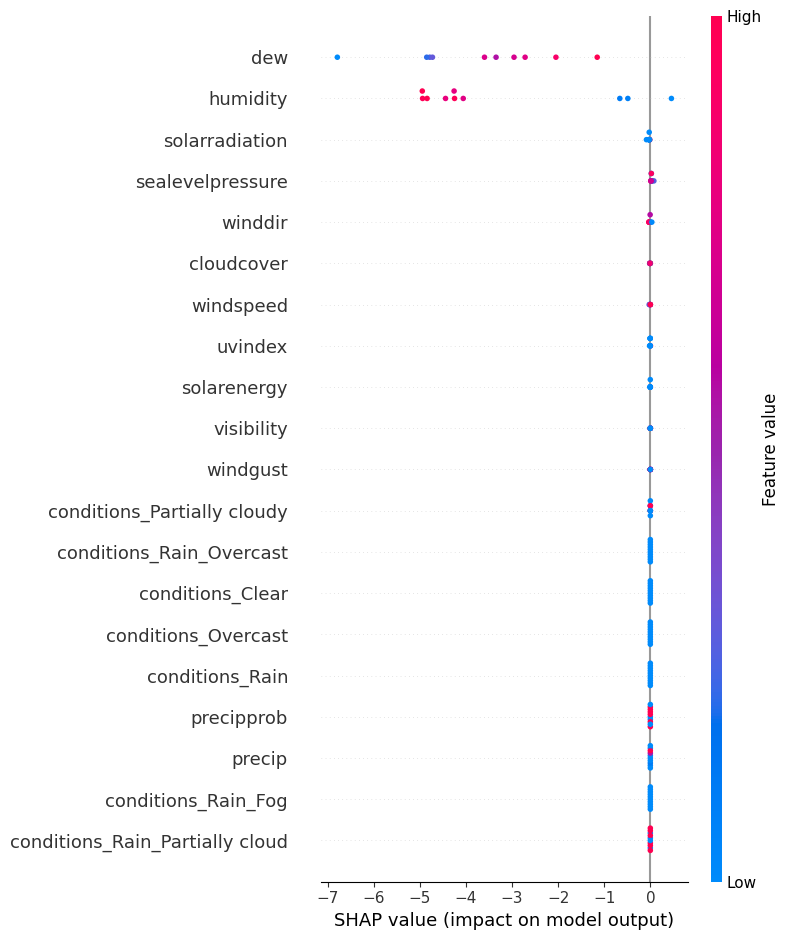

In [94]:
import shap

# Initialiser un explorateur SHAP avec le modèle entraîné
explainer = shap.Explainer(best_lgbm_regressor)

# Calculer les valeurs Shapley pour un échantillon de données (par exemple, les 10 premières instances de test)
shap_values = explainer.shap_values(X_test.iloc[:10, :])

# Afficher les valeurs Shapley pour une instance spécifique
shap.summary_plot(shap_values, X_test.iloc[:10, :])

<font size='4' face='MathJax_Math-italic'>

## **<font color='navy' >Profil Ceteris Paribus (CP)</font>**


Le Profil Ceteris Paribus (CP) est une méthode puissante que nous utilisons en statistiques et en apprentissage automatique pour plonger dans les rouages de nos modèles prédictifs. L'idée est de comprendre comment une variable spécifique influe sur les prédictions du modèle tout en maintenant les autres variables constantes, et cela se déroule en plusieurs étapes.

D'abord, on choisit un point de départ, une instance dans notre jeu de données. C'est comme notre point de référence pour l'analyse. Ensuite, on sélectionne la variable que l'on souhaite examiner, celle qui nous intrigue. On fixe alors les autres variables à un niveau spécifique, souvent à la moyenne, afin de les maintenir constantes.

La partie intéressante arrive quand on fait varier la valeur de la variable choisie. On crée une série de points le long d'une plage de valeurs, représentant différentes situations possibles. À chaque point, on demande à notre modèle de faire une prédiction en fonction de la variation de cette variable.

Enfin, on visualise ces prédictions. Un graphique est souvent la meilleure façon de voir comment la variable choisie impacte les prédictions du modèle. C'est là que l'expression "Ceteris Paribus" prend tout son sens, car on isole l'effet d'une seule variable, tout en gardant le reste constant.

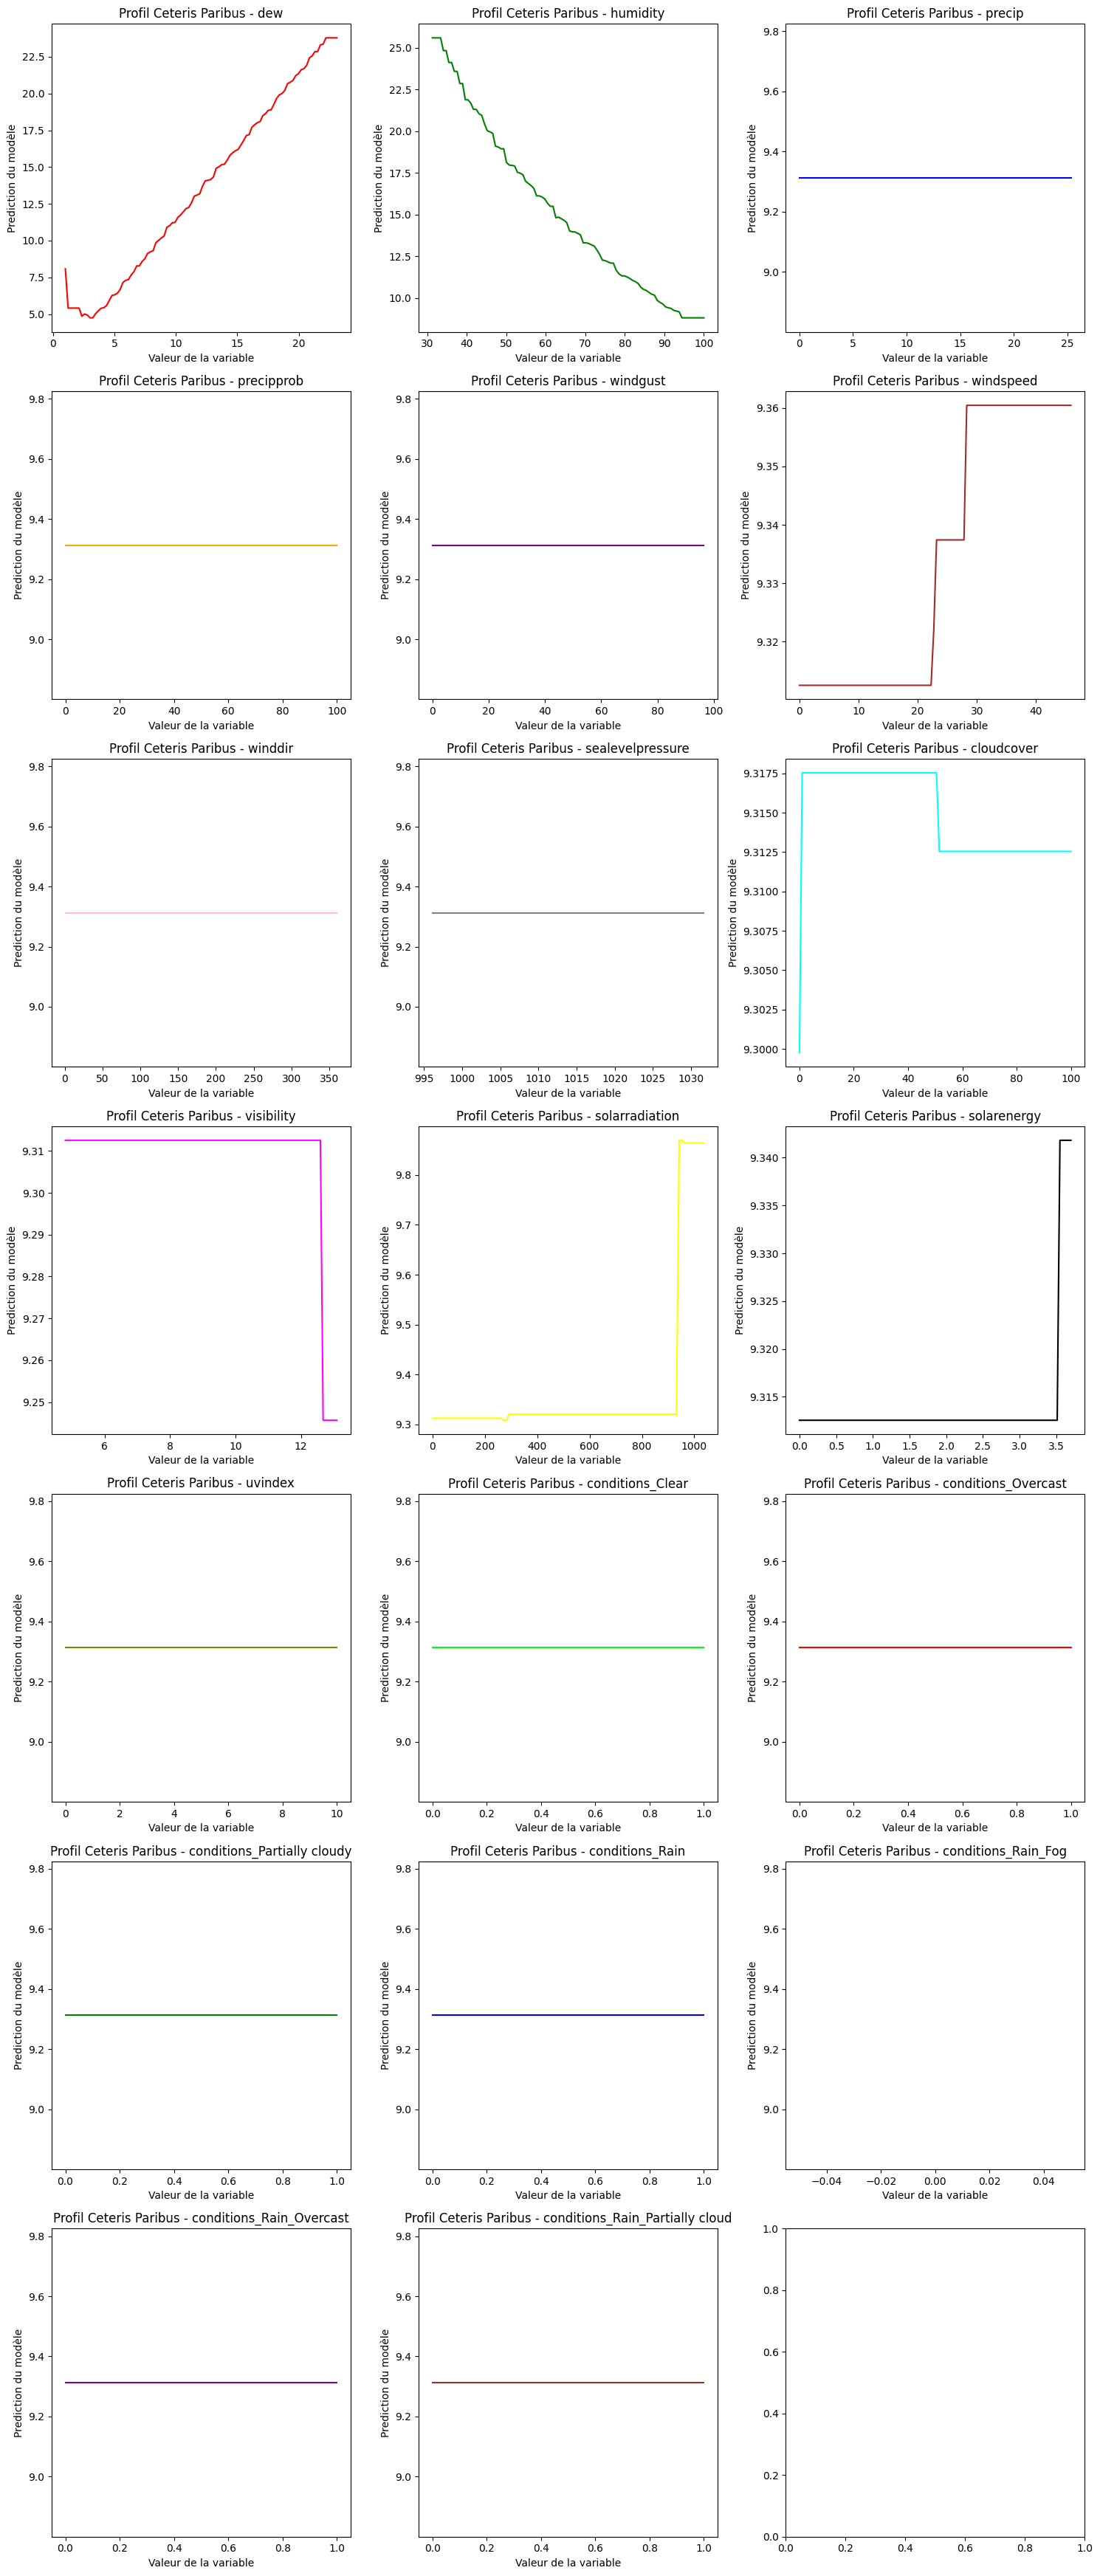

In [95]:
import warnings
from pandas.errors import SettingWithCopyWarning
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

warnings.filterwarnings("ignore", category=SettingWithCopyWarning)

# Choisir une instance spécifique
instance_to_profile = X_test.iloc[0, :]

# Fixer les autres variables (par exemple, à la moyenne)
fixed_values = X_test.mean()

# Définir une liste de couleurs
colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta', 'yellow', 'black', 'olive', 'lime']

# Faites varier chaque variable sur une plage donnée et stocker les graphiques
num_variables = len(X_test.columns)
num_plots_per_row = 3
num_rows = int(np.ceil(num_variables / num_plots_per_row))

# Définisser une grille de sous-graphiques (nombre de lignes, 3 colonnes)
fig, axs = plt.subplots(num_rows, num_plots_per_row, figsize=(15, 5 * num_rows))

# Aplatir les tableaux pour simplifier l'indexation
axs = axs.flatten()

for i, variable_to_vary in enumerate(X_test.columns):
    # Vérifier si la variable est de type numérique
    if np.issubdtype(X_test[variable_to_vary].dtype, np.number):
        # Faites varier la variable choisie sur une plage donnée
        vary_range = np.linspace(X_test[variable_to_vary].min(), X_test[variable_to_vary].max(), 100)

        # Stocker les prédictions du modèle pour chaque valeur de la variable choisie
        predictions = []

        for value in vary_range:
            instance_copy = instance_to_profile.copy()
            instance_copy[variable_to_vary] = value
            instance_df = pd.DataFrame(instance_copy.values.reshape(1, -1), columns=X_test.columns)
            prediction = best_lgbm_regressor.predict(instance_df)[0]  # Utiliser le modèle XGBRegressor

            predictions.append(prediction)

        # Créer un graphique pour chaque variable avec une couleur spécifique
        axs[i].plot(vary_range, predictions, label=variable_to_vary, color=colors[i % len(colors)])
        axs[i].set_xlabel('Valeur de la variable')
        axs[i].set_ylabel('Prediction du modèle')
        axs[i].set_title('Profil Ceteris Paribus - ' + variable_to_vary)

# Ajuster l'espacement entre les sous-graphiques pour éviter la superposition des titres
plt.tight_layout()

# Afficher les graphiques
plt.show()

<font size='4' face='MathJax_Math-italic'>

## **<font color='orange' > Interprétabilité Globale :</font>**


L'interprétabilité globale concerne la compréhension du modèle dans son ensemble, en examinant comment il prend des décisions sur l'ensemble des données d'entrée. Elle répond à la question : "Comment le modèle prend-il des décisions de manière générale ?"
Des techniques telles que l'importance des caractéristiques, les Partial Dependence Plots (PDP), les SHAP values avec l'interprétation globale, permettent d'analyser le modèle dans son intégralité. Ces méthodes offrent des informations sur la contribution relative de chaque caractéristique à l'ensemble du modèle, les relations entre les caractéristiques, et comment les prédictions varient avec différentes valeurs de caractéristiques.


## **<font color='navy' >Permutation importance</font>**


Cette technique évalue l'importance d'une caractéristique en permutant les valeurs de la caractéristique et en observant l'impact sur le score du modèle.

In [96]:
!pip install eli5

In [97]:
import eli5
from eli5.sklearn import PermutationImportance


# Initialiser la permutation importance1
perm_importance = PermutationImportance(best_lgbm_regressor, random_state=42).fit(X_test, y_test)

# Afficher l'importance des caractéristiques
eli5.show_weights(perm_importance, feature_names=X_test.columns.tolist())

Weight,Feature
1.4626 ± 0.0187,dew
0.7315 ± 0.0127,humidity
0.0027 ± 0.0009,solarradiation
0.0005 ± 0.0002,cloudcover
0.0002 ± 0.0000,uvindex
0.0000 ± 0.0001,solarenergy
0.0000 ± 0.0000,conditions_Partially cloudy
0 ± 0.0000,conditions_Rain_Overcast
0 ± 0.0000,precip
0 ± 0.0000,precipprob


<font size='4' face='MathJax_Math-italic'>


* **feelslike :** Cette caractéristique a le poids le plus élevé, indiquant qu'elle a une influence significative sur les prédictions du modèle. Cela suggère que la température ressentie est cruciale pour expliquer les variations dans la variable cible.

* **humidity :** Bien que le poids soit faible par rapport à feelslike, l'humidité semble avoir une certaine influence positive sur les prédictions. Cependant, l'impact est beaucoup moins important que celui de feelslike.

* **windspeed :** La vitesse du vent a également un poids positif, indiquant qu'elle contribue modestement aux prédictions.

* **Autres caractéristiques :** Les autres caractéristiques ont des poids nuls ou proches de zéro, suggérant qu'elles n'ont pas d'influence significative sur les prédictions du modèle. Ces caractéristiques peuvent être considérées comme ayant une importance limitée dans ce modèle particulier.


==> Selon la permutation importance, feelslike est la caractéristique la plus importante, suivie de l'humidité et de la vitesse du vent. Les autres caractéristiques semblent avoir une influence négligeable sur les prédictions du modèle.


<font size='4' face='MathJax_Math-italic'>

## **<font color='navy' >SHAP (SHapley Additive exPlanations) </font>**
SHAP (SHapley Additive exPlanations) est basé sur la théorie des jeux et les valeurs de Shapley, qui proviennent du domaine de la théorie des coalitions. Cette méthode offre des explications individualisées et cohérentes pour les prédictions de modèles, que ce soit à l'échelle globale ou locale.

### Interprétation Globale avec SHAP :

* **Valeurs de Shapley :**

SHAP attribue une valeur de Shapley à chaque caractéristique pour chaque prédiction. Ces valeurs représentent la contribution marginale moyenne d'une caractéristique à la prédiction sur toutes les permutations possibles des caractéristiques.

* **Valeurs Moyennes Globales :**

Les valeurs de Shapley individuelles sont ensuite agrégées pour obtenir des valeurs moyennes globales. Cela permet d'identifier l'impact moyen de chaque caractéristique sur les prédictions de l'ensemble du modèle.

* **Graphiques Sommaires :**

Les graphiques sommaires, tels que les "Summary Plots" de SHAP, affichent l'importance relative de chaque caractéristique pour l'ensemble du jeu de données. Ces graphiques sont utiles pour comprendre quelles caractéristiques ont le plus d'influence sur les prédictions du modèle.


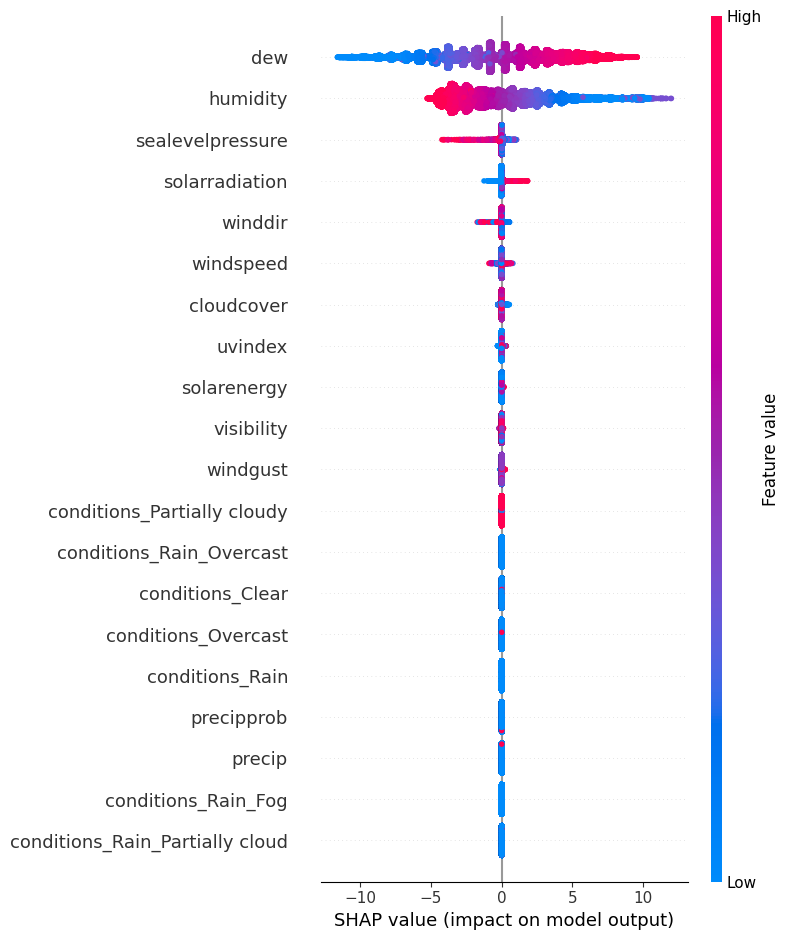

In [98]:
# Calculer les valeurs Shapley pour un échantillon de données (par exemple, les 10 premières instances de test)
shap_values = explainer.shap_values(X_train)

# Afficher les valeurs Shapley pour une instance spécifique
shap.summary_plot(shap_values, X_train)

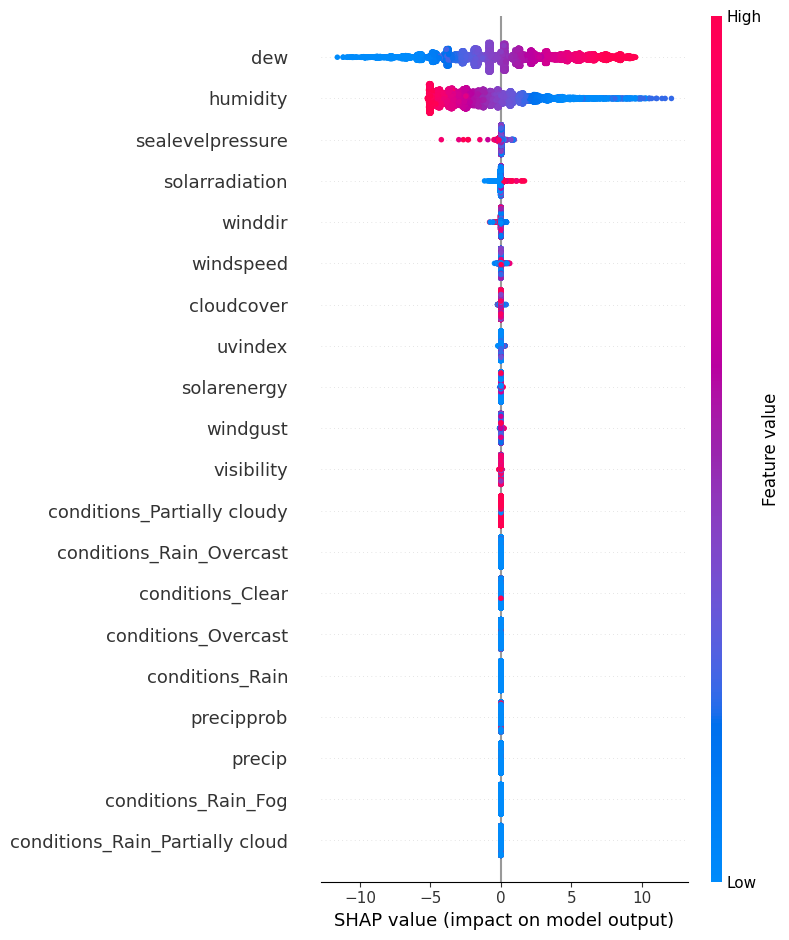

In [99]:
# Calculer les valeurs Shapley pour un échantillon de données (par exemple, les 10 premières instances de test)
shap_values = explainer.shap_values(X_test)

# Afficher les valeurs Shapley pour une instance spécifique
shap.summary_plot(shap_values, X_test)

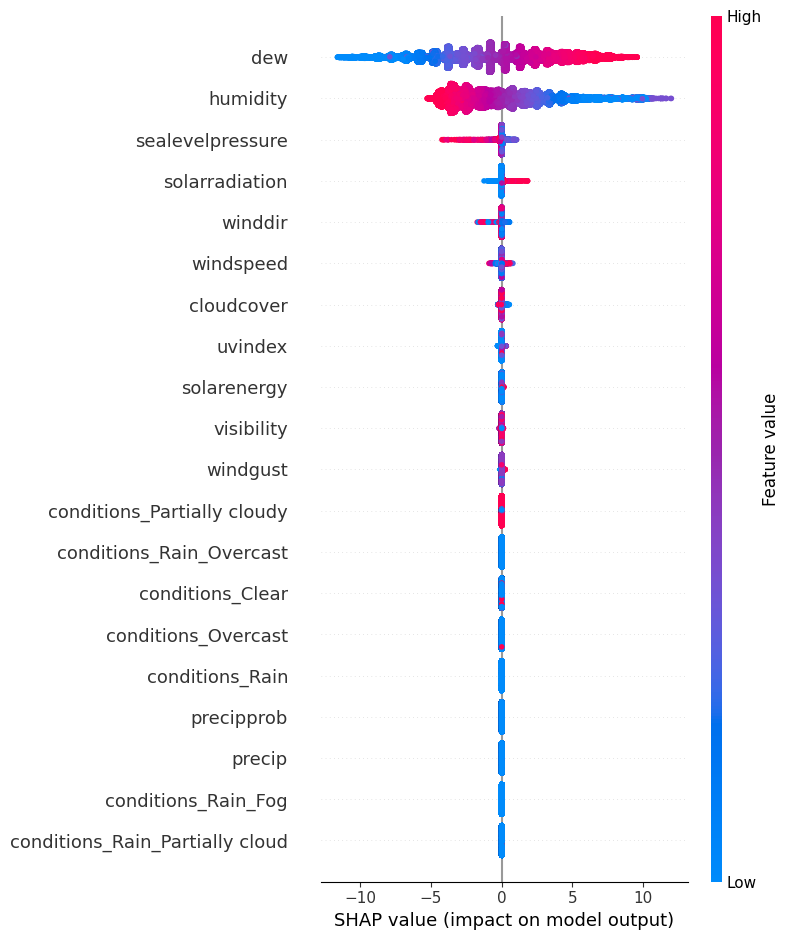

In [100]:
# Calculer les valeurs Shapley pour un échantillon de données (par exemple, les 10 premières instances de test)
shap_values = explainer.shap_values(X_train)

# Afficher les valeurs Shapley pour une instance spécifique
shap.summary_plot(shap_values, X_train)

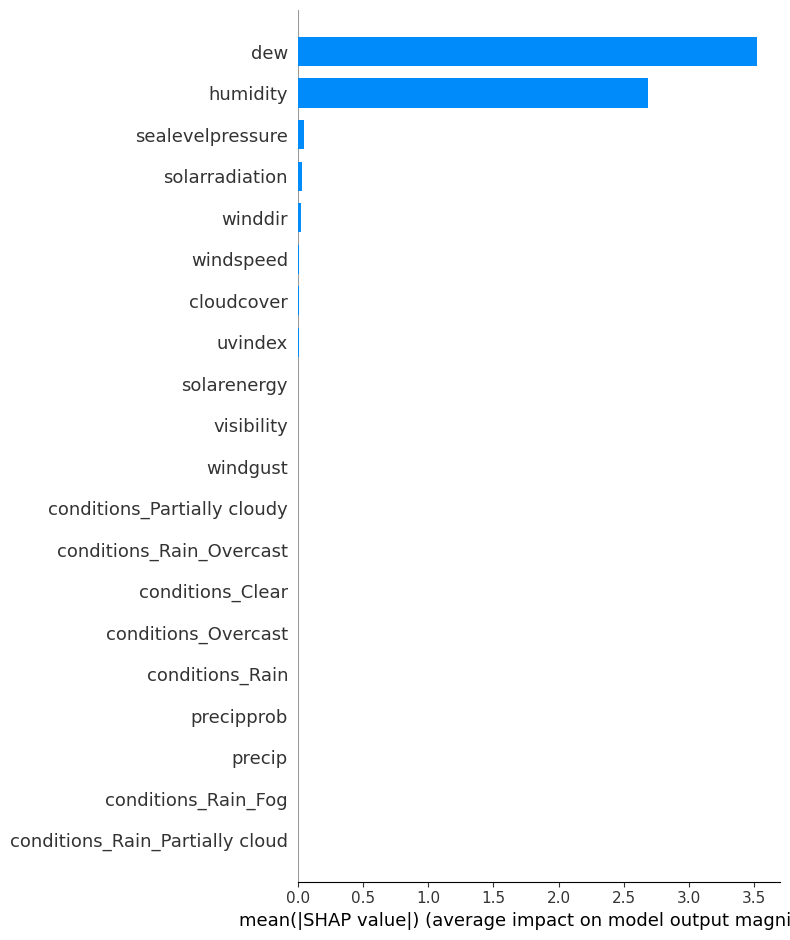

In [101]:
# Calculer les valeurs Shapley pour un échantillon de données
shap_values = explainer.shap_values(X_train)

# Afficher les valeurs Shapley pour une instance spécifique
shap.summary_plot(shap_values, X_train, plot_type="bar")

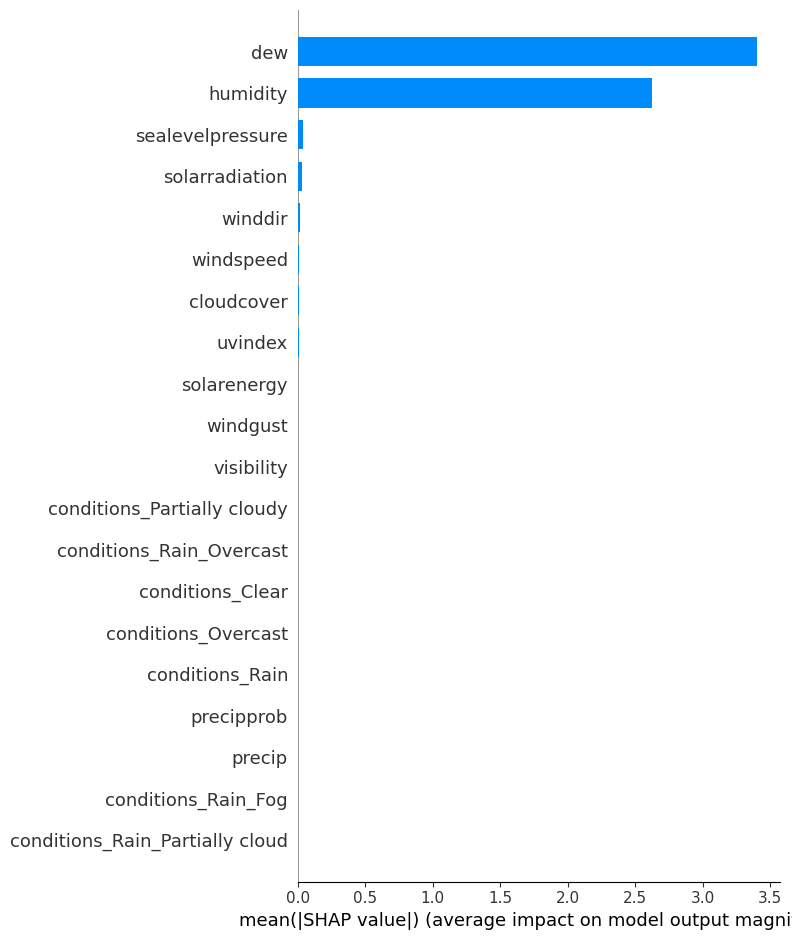

In [102]:
# Calculer les valeurs Shapley pour un échantillon de données
shap_values = explainer.shap_values(X_test)

# Afficher les valeurs Shapley pour une instance spécifique
shap.summary_plot(shap_values, X_test, plot_type="bar")

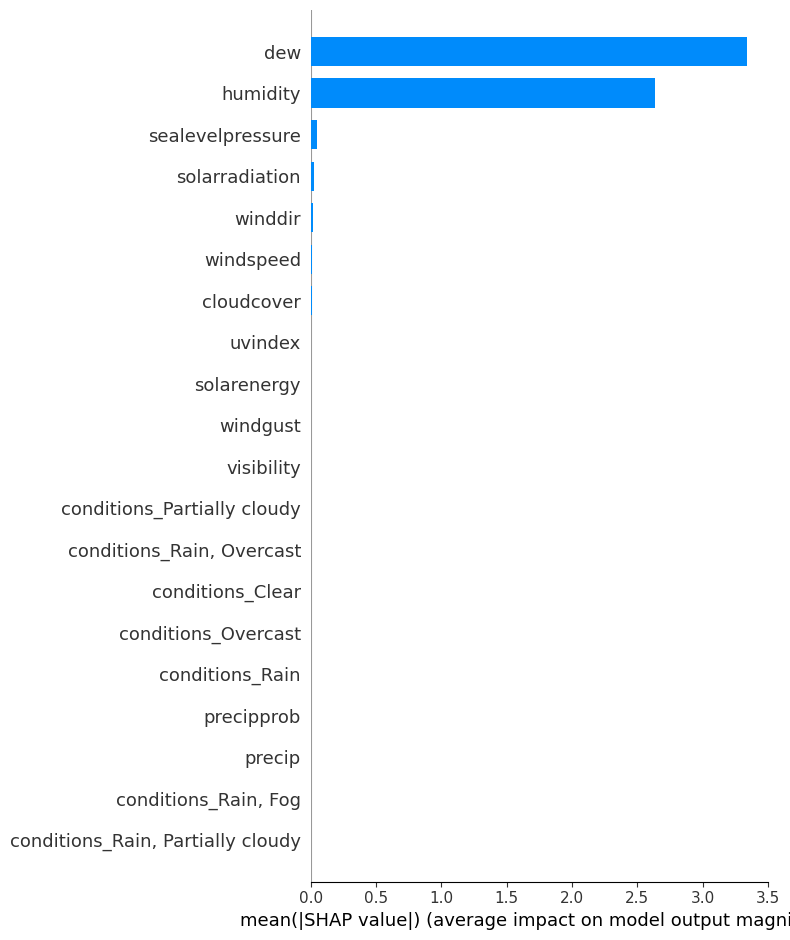

In [103]:
# Calculer les valeurs Shapley pour un échantillon de données
shap_values = explainer.shap_values(X_val)

# Afficher les valeurs Shapley pour une instance spécifique
shap.summary_plot(shap_values, X_val, plot_type="bar")

<font size='4' face='MathJax_Math-italic'>

## **<font color='navy' >Partial Dependence Plots (PDP)</font>**

La technique de l'interprétation d'arbre, souvent utilisée avec des modèles d'arbres de décision, permet de comprendre comment chaque caractéristique contribue à la prédiction globale du modèle. L'interprétation d'arbre peut être réalisée à l'aide de différentes méthodes, et l'une d'entre elles est l'utilisation d'un outil appelé "Tree Interpreter".

Voici une explication de la technique en utilisant Tree Interpreter :

Séparation des Caractéristiques : Dans un modèle d'arbre de décision, chaque nœud de l'arbre correspond à une décision basée sur une caractéristique spécifique. L'arbre est construit en séparant les données en fonction de ces caractéristiques.

Calcul des Contributions : L'interpréteur d'arbre calcule la contribution de chaque caractéristique à la prédiction globale du modèle. Pour chaque prédiction, il examine quelles caractéristiques ont été utilisées pendant le passage dans l'arbre et comment elles ont influencé la sortie.

Visualisation des Contributions : Les contributions calculées peuvent être visualisées sous forme de graphique à barres. Chaque barre représente la contribution d'une caractéristique spécifique à la prédiction. Une barre positive indique une contribution positive, tandis qu'une barre négative indique une contribution négative.

Compréhension Globale et Locale : L'interprétation d'arbre permet de comprendre l'impact global de chaque caractéristique sur les prédictions du modèle, ainsi que l'impact local pour des prédictions spécifiques.

Détection des Caractéristiques Importantes : En examinant les contributions, on peut identifier les caractéristiques qui ont le plus d'influence sur les prédictions du modèle. Cela peut aider à hiérarchiser l'importance des caractéristiques dans le processus de prise de décision du modèle.

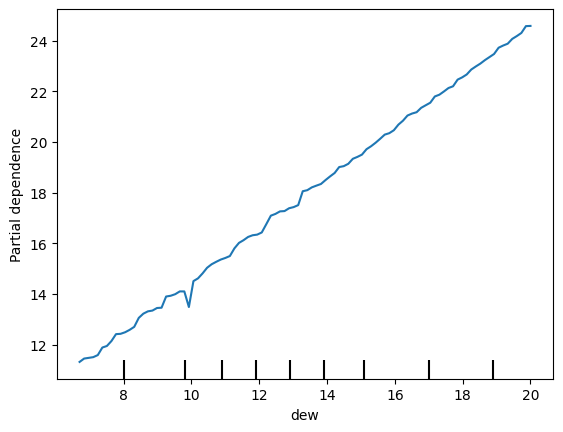

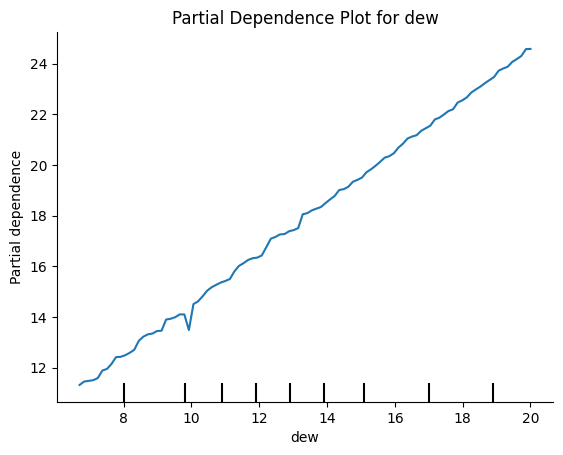

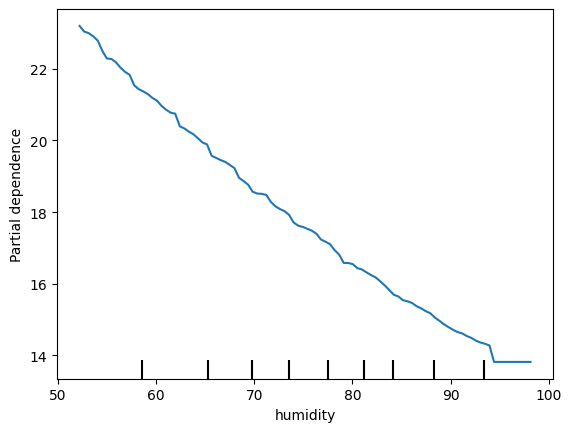

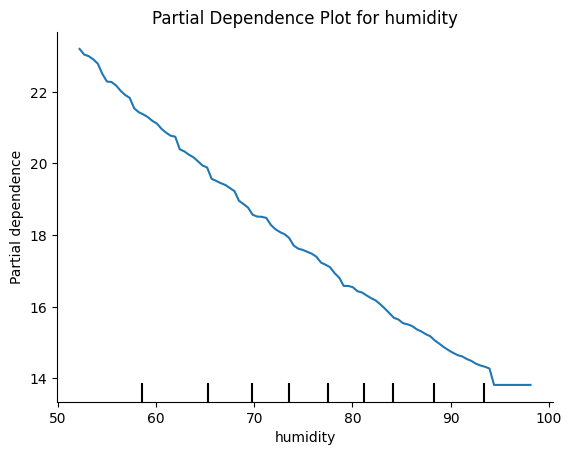

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.


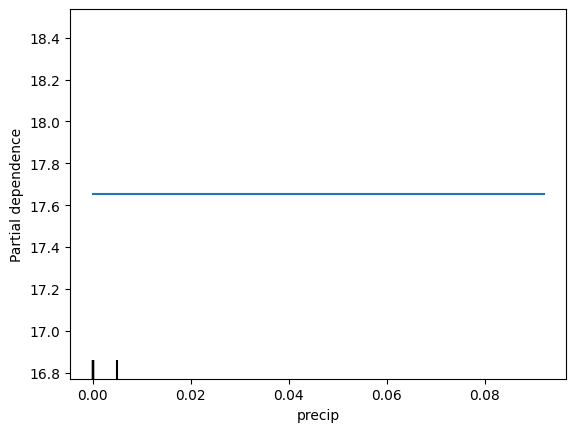

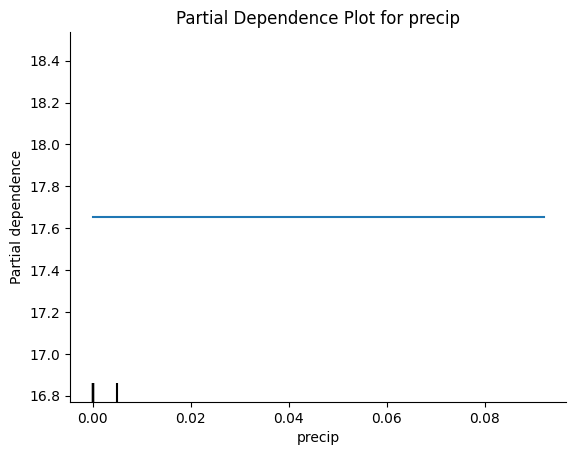

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.


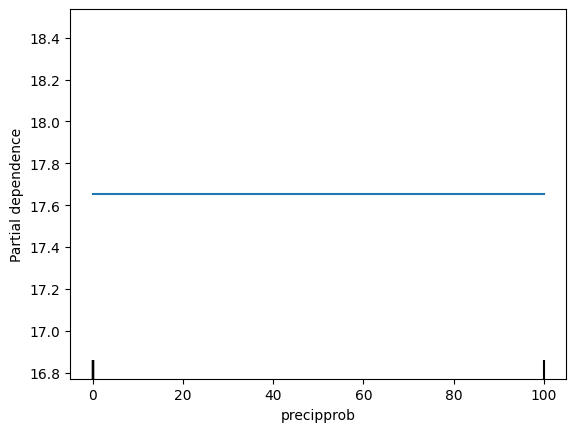

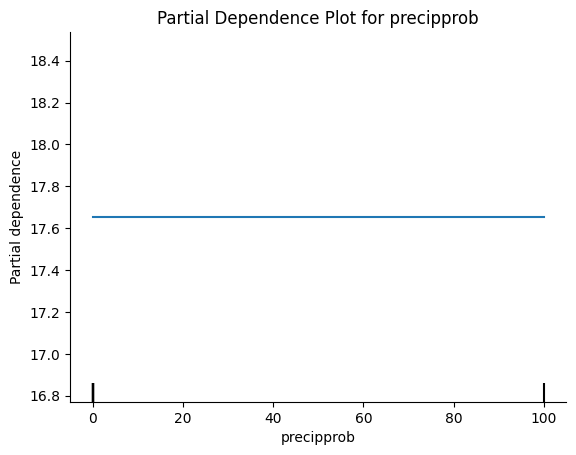

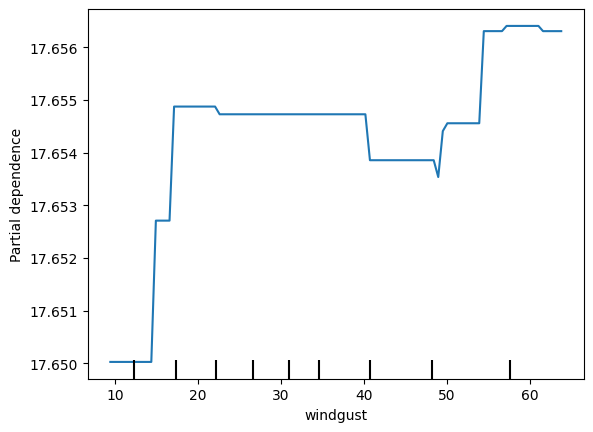

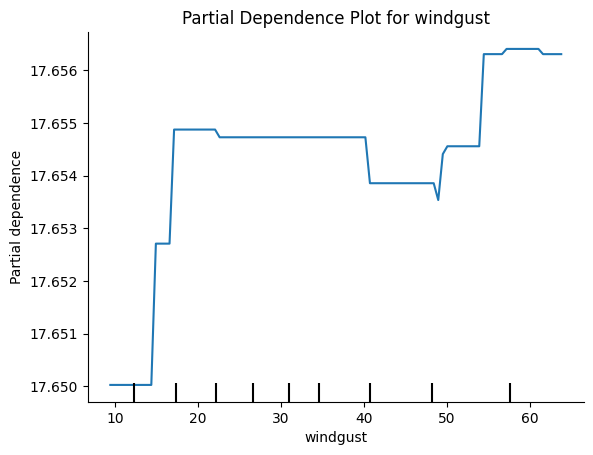

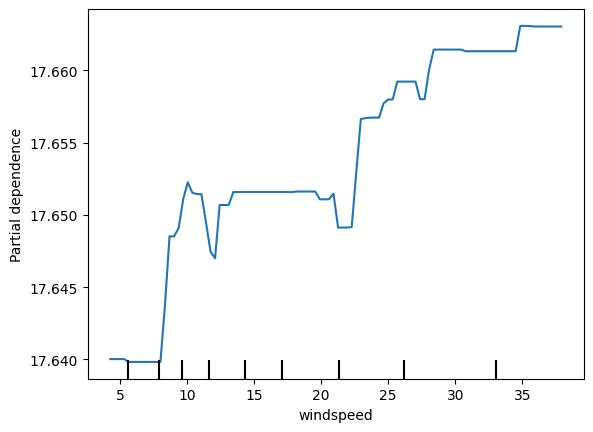

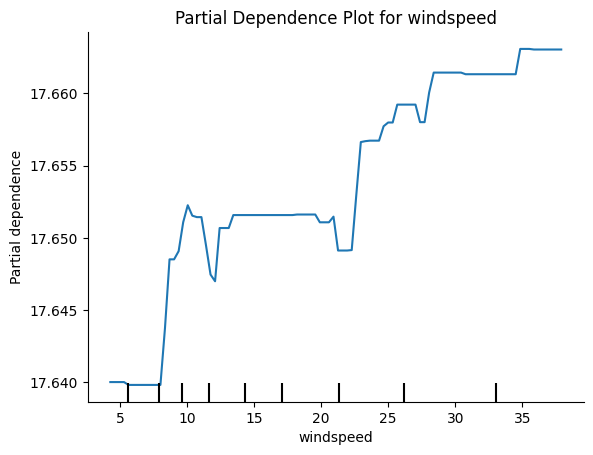

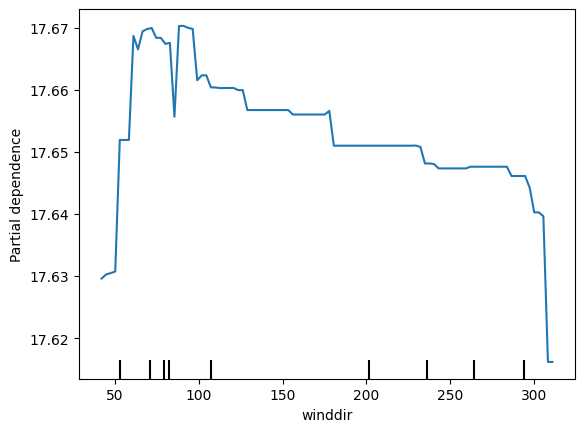

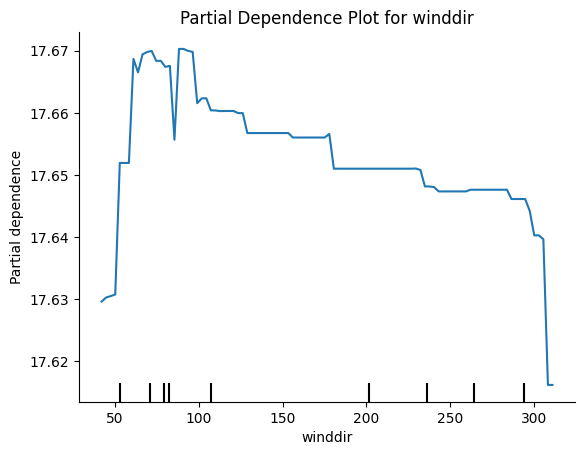

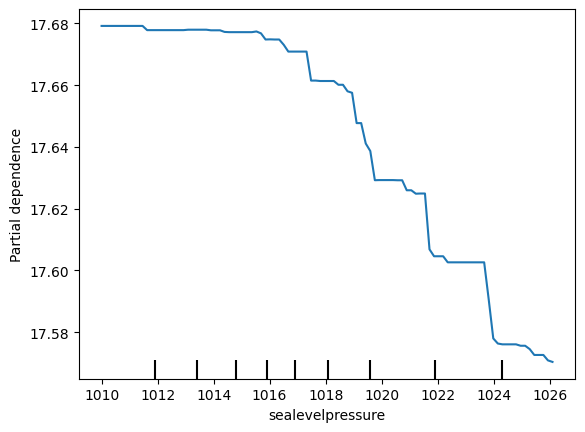

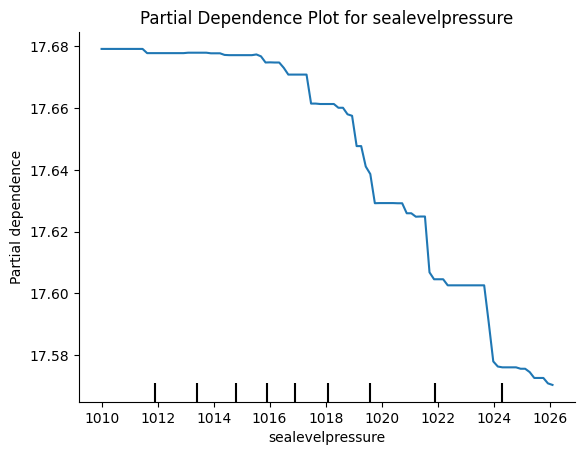

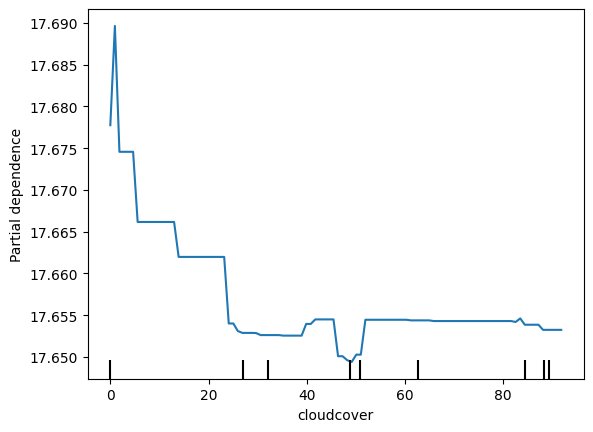

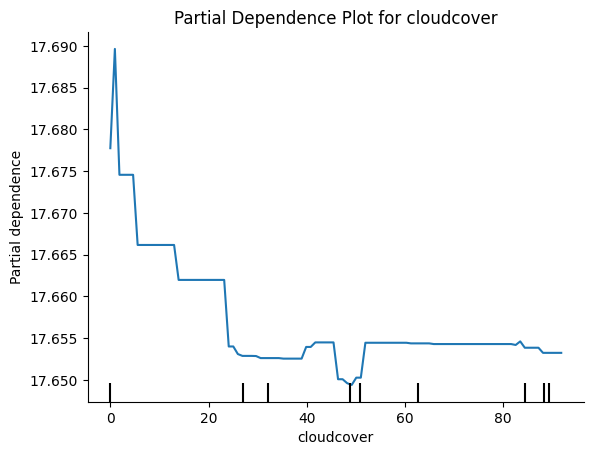

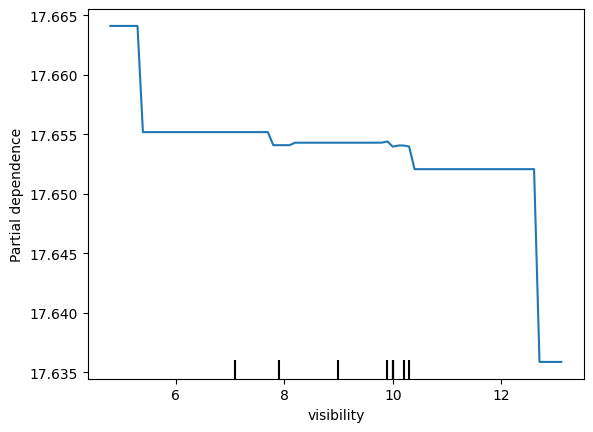

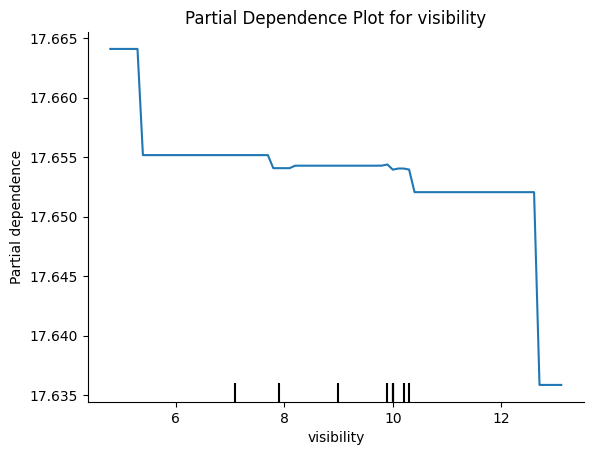

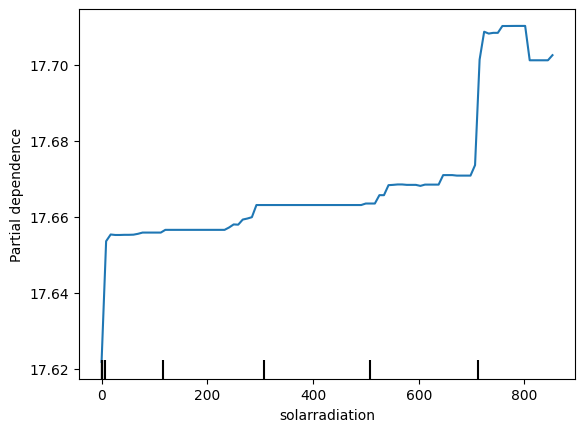

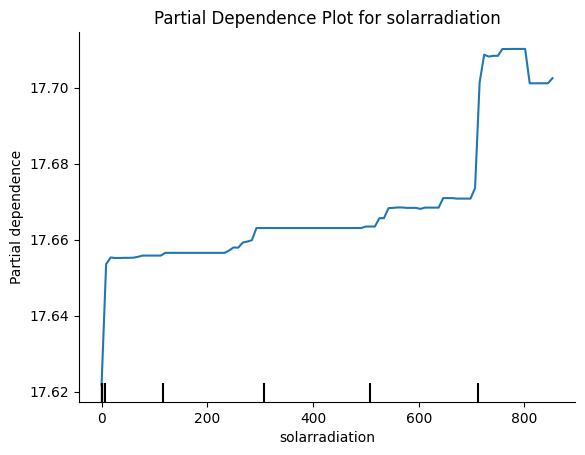

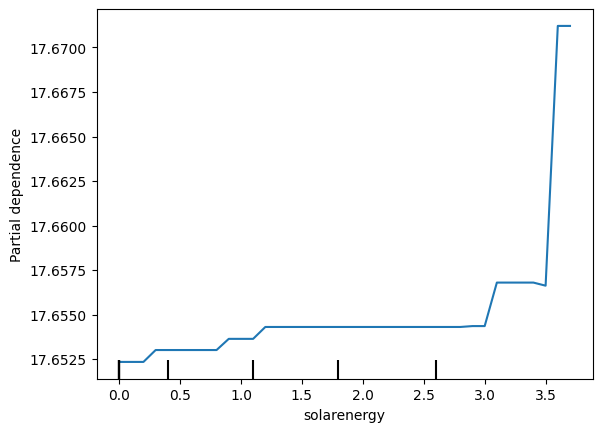

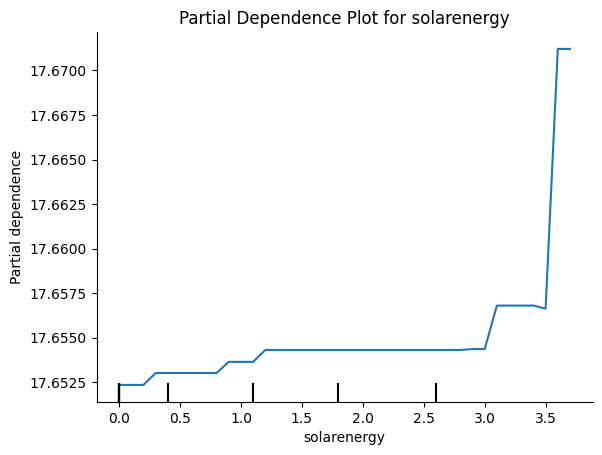

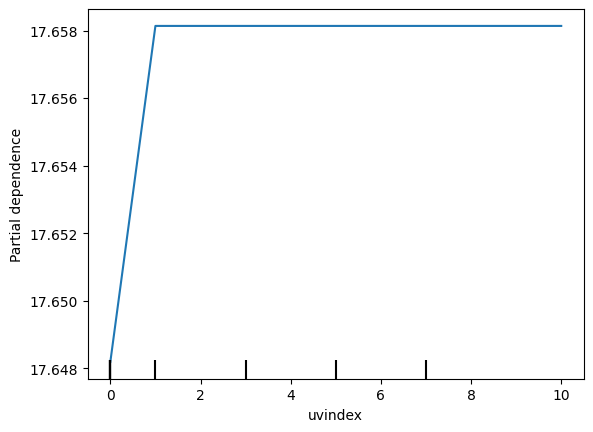

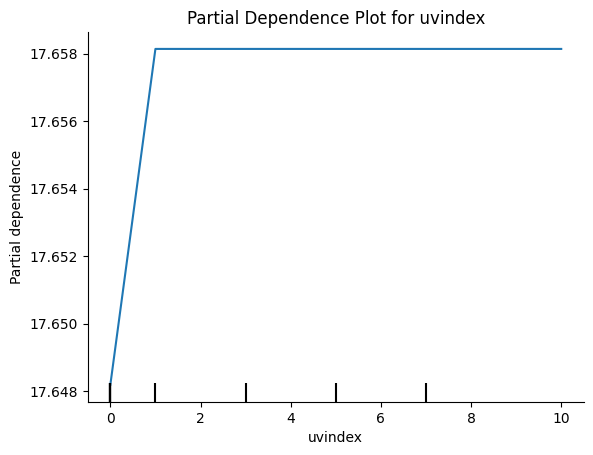

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.


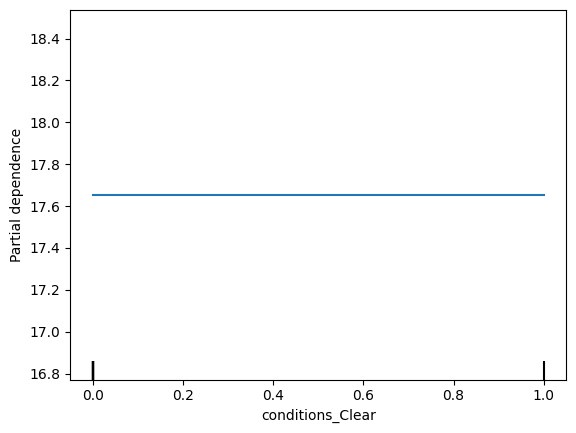

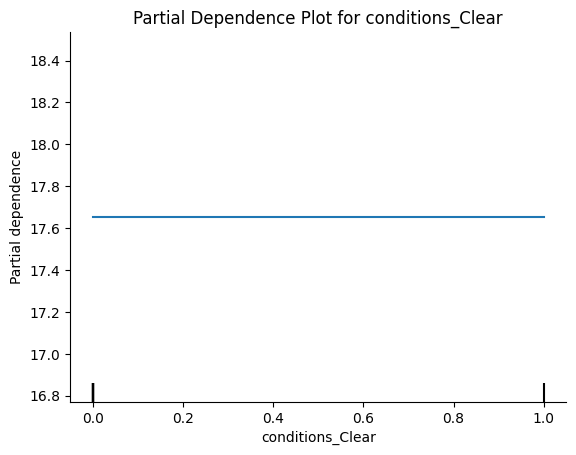

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.


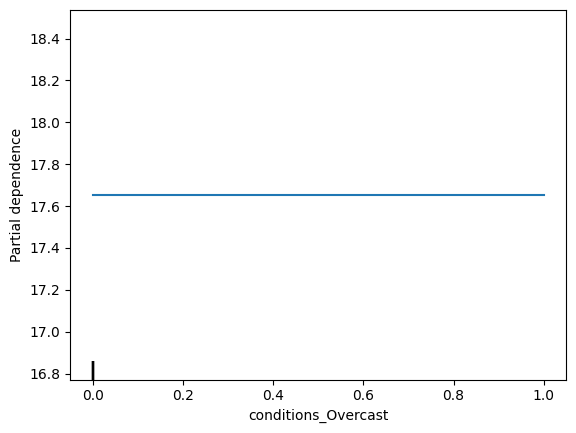

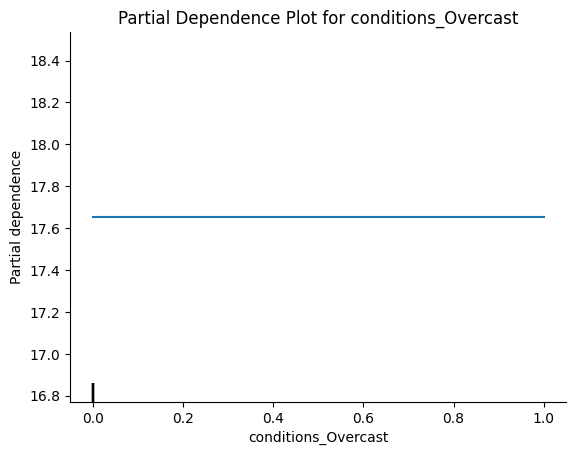

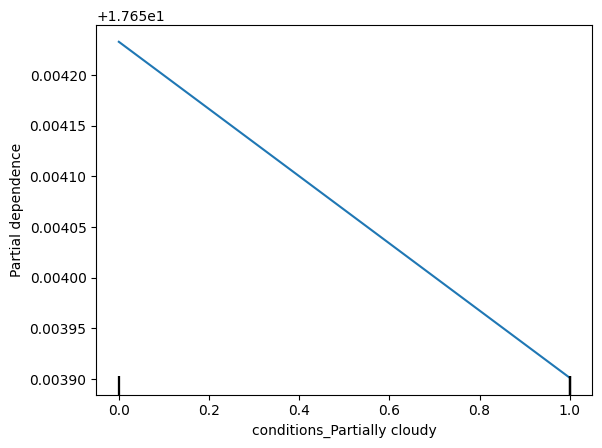

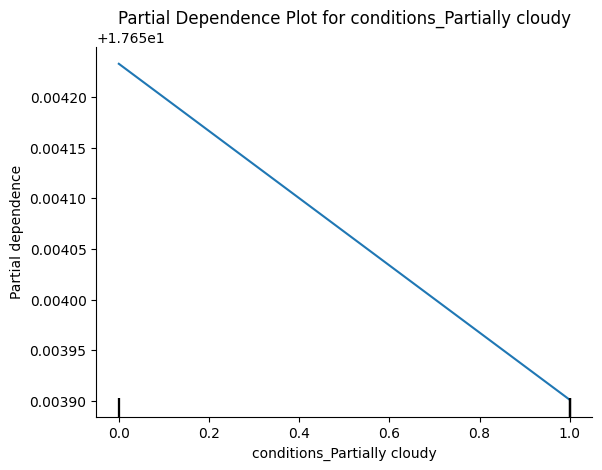

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.


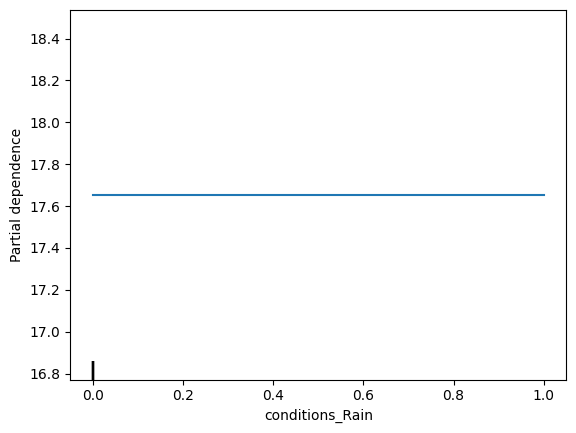

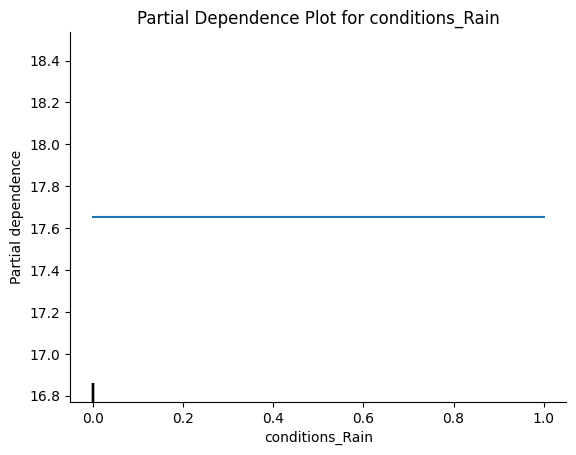

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.


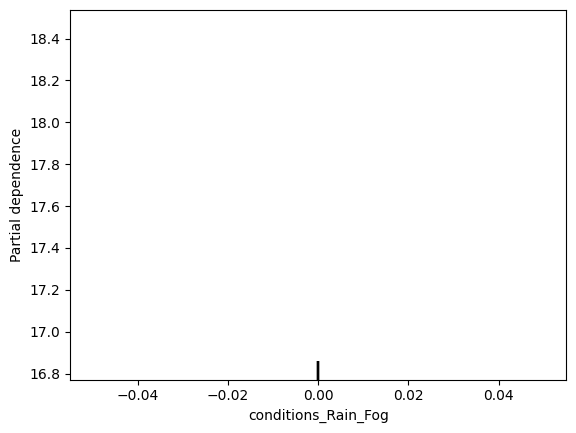

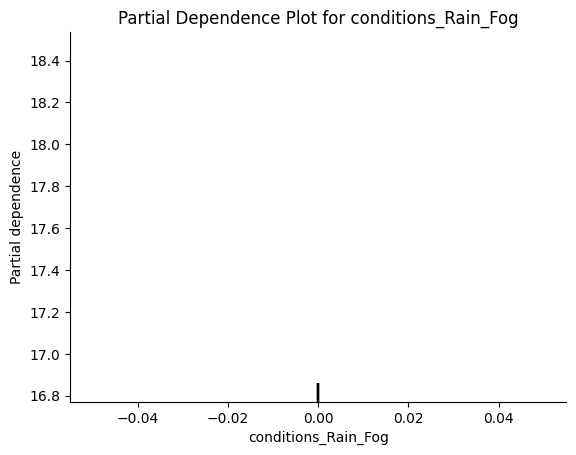

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.


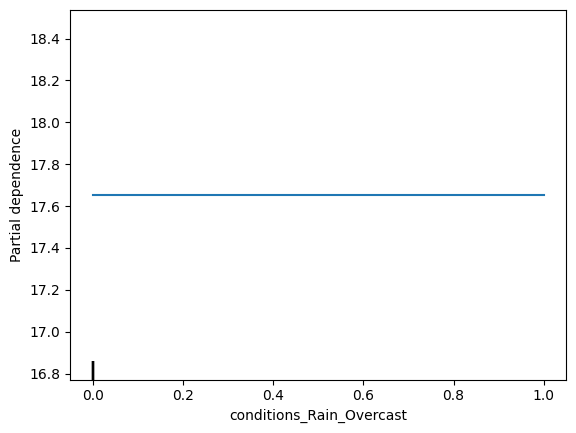

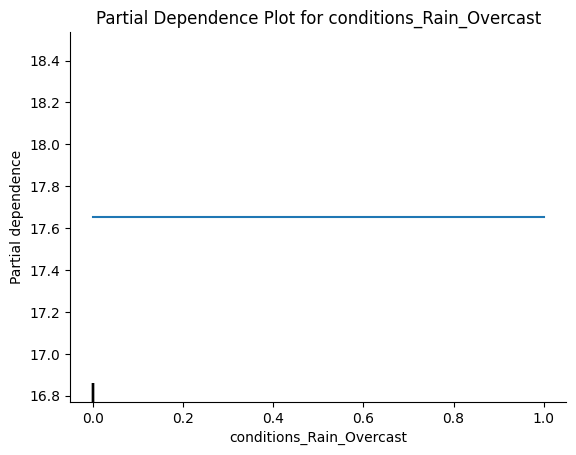

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.


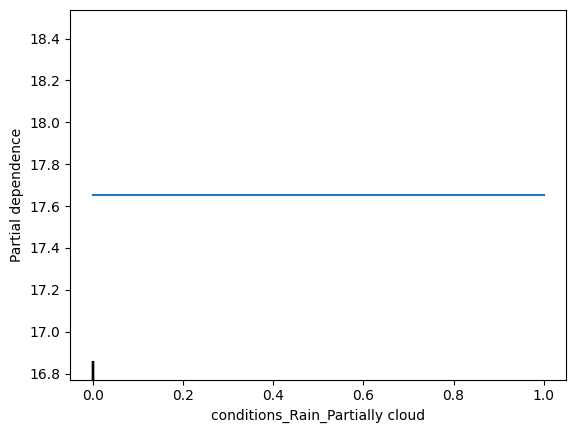

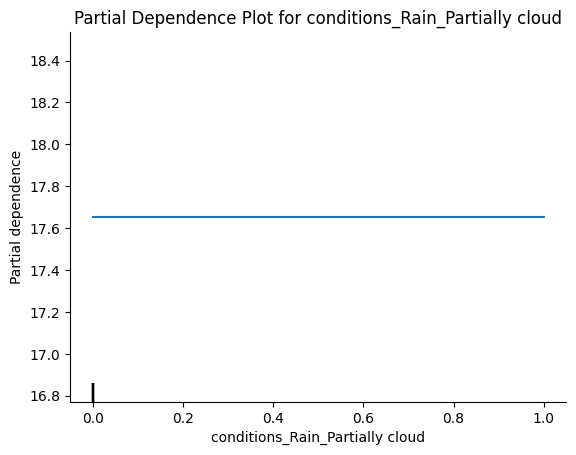

In [104]:
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Ensemble pour suivre les variables déjà traitées
processed_variables = set()

# Parcourir toutes les variables de X_test
for feature_to_plot in X_test.columns:
    # Vérifier si la variable est de type numérique et n'a pas été traitée
    if np.issubdtype(X_test[feature_to_plot].dtype, np.number) and feature_to_plot not in processed_variables:
        # Ajouter la variable à l'ensemble des variables traitées
        processed_variables.add(feature_to_plot)

        # Calculer la dépendance partielle
        pdp, axes = partial_dependence(best_lgbm_regressor, X_test, features=[feature_to_plot])

        # Créer le display
        display = PartialDependenceDisplay.from_estimator(
            best_lgbm_regressor,
            X_test,
            features=[feature_to_plot],
        )

        # Personnaliser le graphique avec Matplotlib (facultatif)
        # Par exemple, ajouter un titre au graphique
        display.plot()
        plt.title(f'Partial Dependence Plot for {feature_to_plot}')

        # Afficher le graphique avec Seaborn
        sns.despine()  # Facultatif : personnaliser l'apparence avec Seaborn
        plt.show()

In [105]:
import joblib

# Enregistrer le modèle entraîné
model_filename = 'best_lgbm_regressor.joblib'
joblib.dump(best_lgbm_regressor, model_filename)

print(f"Modèle enregistré sous le nom '{model_filename}'")

Modèle enregistré sous le nom 'best_lgbm_regressor.joblib'
